## Computing $p(f_\mathrm{DM}~|~\mathrm{data})$, using O1-O2-O3a-O3b events

In [1]:
from __future__ import division
import numpy as np
import scipy
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import math
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
from scipy.integrate import cumtrapz 
from scipy.special import erf
import math
from matplotlib import cm
import warnings
warnings.filterwarnings("ignore")

In [2]:
rc_params = {'axes.labelsize': 14,
             'axes.titlesize': 14,
             'font.size': 14,
             'lines.linewidth' : 3,
             'legend.fontsize': 14,
             'xtick.labelsize': 12,
             'ytick.labelsize': 12,
             'text.usetex' : True,
            }
rcParams.update(rc_params)

from matplotlib import rc

rc('text.latex', preamble='\\usepackage{txfonts}')
rc('text', usetex=True)
rc('font', family='serif')
rc('font', serif='times')
rc('mathtext', default='sf')
rc("lines", markeredgewidth=1)
rc("lines", linewidth=2)

## Calculate the posterior of lensing fraction from O1-O2-O3 data

In [3]:
directory = "../data/"
filename_analytic = directory+"bbh_posterior_gap-closed_mp_jeffreys.txt"
x_bbh, y_bbh = np.loadtxt(filename_analytic,unpack=True)
posterior_lambda_gstlal = interp1d(x_bbh,y_bbh,kind="cubic")  

In [4]:
'''This is to get the posterior distribution of Lambda (Poisson mean of the detected events)'''

def posterior_lambda_poisson(Lambda, n_events, prior='flat'):
    """ calculate the posterior of Lambda from n observed events"""
    
    if prior=='flat':
        P_Lambda = Lambda**n_events*np.exp(-Lambda)/math.factorial(n_events)
    elif prior=='logflat':
        P_Lambda = Lambda**n_events*np.exp(-Lambda)/math.factorial(n_events)/Lambda
    elif prior=='Jeffreys':
        P_Lambda = Lambda**n_events*np.exp(-Lambda)/math.factorial(n_events)/np.sqrt(Lambda)
    else: 
        raise ValueError('Unknown prior')
    
    return P_Lambda/np.trapz(P_Lambda, Lambda)

def posterior_lambda_gaussian(Lambda, n_events):
    """ calculate the posterior of Lambda from n observed events (gaussian approximation)"""
    mu, sigma = n_events, np.sqrt(n_events)
    return np.exp(-0.5*(Lambda-mu)**2./sigma**2)/np.sqrt(2*np.pi)/sigma


'''This is to calculate the posterior distribution of the lensing fraction (u := Lamba_l/Lambda)'''

def posterior_lensing_frac(u_vec, n_events, prior='flat'): 
    """ calculate the posterior on the fraction of lensed events from the observation 
    of zero lensed events """
    
    P_u = np.zeros_like(u_vec)
    umax = np.max(u_vec)
    Lambda = np.linspace(1e-6,5*n_events,int(1e4))

    if prior=='flatold':
        for iu, u in enumerate(u_vec): 
            P_u[iu] = np.trapz(Lambda**(n_events+1.)*np.exp(-Lambda*(1.+u))/(1.-np.exp(-Lambda)), \
                               Lambda)/math.factorial(n_events)
    elif prior=='flat':
        #for iu, u in enumerate(u_vec): 
        # P_u[iu] = np.trapz(Lambda**n_events*np.exp(-Lambda*(1.+u)), Lambda)            
        # P_u = (u_vec+1)**-(n_events+1)
        for iu, u in enumerate(u_vec): 
            P_u[iu] = np.trapz(Lambda**(n_events+1)*np.exp(-Lambda*(1.+u))/(1-np.exp(-umax*Lambda)), \
                               Lambda)            
         
    elif prior=='Jeffreys':
        #for iu, u in enumerate(u_vec): 
        #   P_u[iu] = np.trapz(Lambda**n_events*np.exp(-Lambda*(1.+u)), Lambda)/np.sqrt(u) 
        P_u = (u_vec+1)**-(n_events+1)/np.sqrt(u_vec)
        for iu, u in enumerate(u_vec): 
            P_u[iu] = np.trapz(Lambda**n_events*np.exp(-Lambda*(1.+u))/erf(np.sqrt(umax*Lambda)),\
                               Lambda)/np.sqrt(u) 

    return P_u/np.trapz(P_u, u_vec)    

def posterior_lensing_frac_large_n_limit(u_vec, n_events, prior='flat'): 
    """ calculate the posterior on the fraction of lensed events from the observation 
    of zero lensed events. Use Gaussian distribution instead of Poisson. Valid in the limit 
    of large N_events """
    
    P_u = np.zeros_like(u_vec)
    umax = np.max(u_vec)
    Lambda = np.linspace(1e-6,5*n_events,int(1e4))
    
    if prior=='flat':
        gauss_term = Lambda*np.exp(-(Lambda-n_events)**2/(2*n_events))/(1-np.exp(-umax*Lambda))
        for iu, u in enumerate(u_vec): 
            P_u[iu] = np.trapz(gauss_term*np.exp(-Lambda*u), Lambda)            
         
    elif prior=='Jeffreys':
        gauss_term = np.exp(-(Lambda-n_events)**2/(2*n_events))/erf(np.sqrt(umax*Lambda))
        for iu, u in enumerate(u_vec): 
            P_u[iu] = np.trapz(gauss_term*np.exp(-Lambda*u), Lambda)/np.sqrt(u) 

    return P_u/np.trapz(P_u, u_vec) 


'''This is to calculate the posterior distribution of f_DM from the posterior of u'''

def posterior_fdm(n_events, fdm_vec, u_vec, du_dfdm_vec, prior='flat', larg_n_limit=False): 
    """ calculate the f_DM posterior from the observation of zero lensed events
    n_events: total num of events 
    fdm_vec: f_dm vector 
    u_vec: u vector corresponding to fdm_vec 
    du_dfdm_vec: Jacobian du/d_fdm """
    
    # calculate the posterior on f_DM 
    if larg_n_limit==False: 
        P_fdm = posterior_lensing_frac(u_vec, n_events, prior=prior)*du_dfdm_vec
    elif larg_n_limit==True: 
        P_fdm = posterior_lensing_frac_large_n_limit(u_vec, n_events, prior=prior)*du_dfdm_vec
    else: 
        raise ValueError('larg_n_limit should be True or False')
        
    # normalize the posteriors 
    P_fdm /= np.trapz(P_fdm, fdm_vec)
    
    # compute the 90% upper limit on f_dm 
    fdm_90 = fdm_vec[np.where(cumtrapz(P_fdm, fdm_vec) >= 0.9)]
    if len(fdm_90) >= 1: 
        fdm_90 = fdm_90[0]
    else:
        fdm_90 =1

    return P_fdm, fdm_90

##  Plot the posteriors of $\Lambda, \Lambda_L$ and $u$

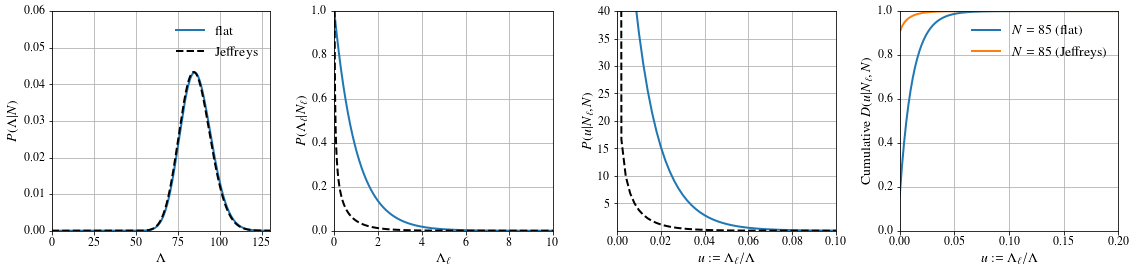

In [17]:
runtag = '2022_01_10_blu_thresh_1.84'

path_plot = '/home1/soummyadip.basak/lensing/DM_macho_constrain/sim_data/soummyadip_o3b/plots/final/'

# create vectors at which the posteriors will be evaluated 

Lambda_vec = np.linspace(1e-6,130,10000)   # event rate 
u_vec = np.linspace(1e-6, 1, 500)          # fraction of lensed events 

# plot posteriors 
plt.figure(figsize=(16,4))
plt.subplot(141)
plt.plot(Lambda_vec, posterior_lambda_poisson(Lambda_vec, 85, prior='flat'), lw=2, label='flat')
plt.plot(Lambda_vec, posterior_lambda_poisson(Lambda_vec, 85, prior='Jeffreys'), lw=2, label='Jeffreys',\
         color='k', ls='--')
plt.xlim(0,130); plt.ylim(0,0.06)
plt.xlabel('$\Lambda$')
plt.ylabel('$P(\Lambda|N)$')
plt.legend(frameon=False)
plt.grid()


plt.subplot(142)
plt.plot(Lambda_vec, posterior_lambda_poisson(Lambda_vec, 0, prior='flat'), label='flat')
plt.plot(Lambda_vec, posterior_lambda_poisson(Lambda_vec, 0, prior='Jeffreys'), color='k', ls='--',\
         label='$N_L = 0$ (jeffreys)')
plt.xlim(0,10); plt.ylim(0,1)
plt.xlabel('$\Lambda_\ell$')
plt.ylabel('$P(\Lambda_\ell|N_\ell)$')
#plt.legend(frameon=False)
plt.grid()


plt.subplot(143)
plt.plot(u_vec, posterior_lensing_frac(u_vec, n_events=85, prior='flat'), label='$N = 54$ (flat)')
plt.plot(u_vec, posterior_lensing_frac(u_vec, n_events=85, prior='Jeffreys'), color='k', ls='--',\
         label='$N = 85$ (Jeffreys)')
plt.xlim(0,0.1); plt.ylim(1e-3,40)
plt.xlabel('$u := \Lambda_\ell/\Lambda$')
plt.ylabel('$P(u|N_\ell, N)$')
#plt.legend(frameon=False)
plt.grid()


plt.subplot(144)
plt.plot(u_vec[:-1], cumtrapz(posterior_lensing_frac(u_vec, n_events=85, prior='flat'), u_vec),
         label='$N = 85$ (flat)')
plt.plot(u_vec[:-1], cumtrapz(posterior_lensing_frac(u_vec, n_events=85, prior='Jeffreys'), u_vec),\
         label='$N = 85$ (Jeffreys)')
plt.xlim(0,0.2); plt.ylim(0,1)
plt.xlabel('$u := \Lambda_\ell/\Lambda$')
plt.ylabel('Cumulative $D(u |N_\ell, N)$')
plt.legend(frameon=False)
plt.grid()
plt.tight_layout()
plt.savefig(path_plot+'u_posteriors_%s.pdf' %runtag)
plt.show()

## ln$B^L_U = 1.84$ (log$_{10}B^L_U = 0.8$), $N_\mathrm{tot} = 85$ (Including O3b PSD) for power-law+peak source mass and Madau-Dickinson redshift distributions

In [5]:
jac_file_o1 = '../sim_data/soummyadip_o3b/posterior_data/'+\
'machodm_lensing_frac_jacobian_H1L1_O1_psd_zsmax1.2_2022-01-10_bluthresh_1.84_constr_min.npz'
jac_file_o2 = '../sim_data/soummyadip_o3b/posterior_data/'+\
'machodm_lensing_frac_jacobian_H1L1V1_O2_psd_zsmax1.5_2022-01-10_bluthresh_1.84_constr_min.npz'
jac_file_o3a = '../sim_data/soummyadip_o3b/posterior_data/'+\
'machodm_lensing_frac_jacobian_H1L1V1_O3a_psd_zsmax1.5_2022-01-10_bluthresh_1.84_constr_min.npz'
jac_file_o3b = '../sim_data/soummyadip_o3b/posterior_data/'+\
'machodm_lensing_frac_jacobian_H1L1V1_O3b_psd_zsmax1.5_2022-01-10_bluthresh_1.84_constr_min.npz'

# load the Jacobian data 

D_o1 = np.load(jac_file_o1, allow_pickle=True)
lens_frac_pol_coeff_o1=D_o1['pol_coeff'].ravel()[0]
D_o2 = np.load(jac_file_o2, allow_pickle=True)
lens_frac_pol_coeff_o2=D_o2['pol_coeff'].ravel()[0]
D_o3a = np.load(jac_file_o3a, allow_pickle=True)
lens_frac_pol_coeff_o3a=D_o3a['pol_coeff'].ravel()[0]
D_o3b = np.load(jac_file_o3b, allow_pickle=True)
lens_frac_pol_coeff_o3b=D_o3b['pol_coeff'].ravel()[0]

## Exclusion plot

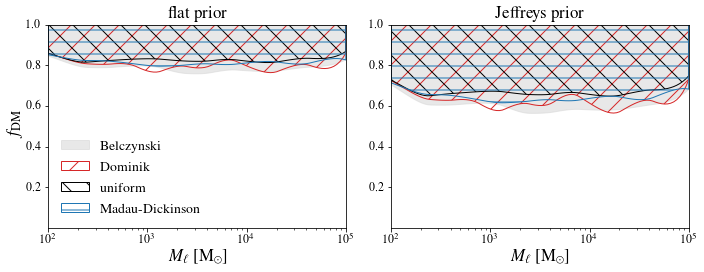

In [29]:
path_plot = '../sim_data/soummyadip_o3b/plots/final/'

# fdm_vec = np.linspace(1e-9,1.,int(1e3))
fdm_vec = np.logspace(-6,0,int(1e4))

# m_lens_vec = np.logspace(1, 6, 21)
m_lens_vec = np.logspace(2, 5, 13)

m_lens_vec = np.delete(m_lens_vec, 9)

blu_thresh = round(0.8*np.log(10), 2)

N_events_O1 = 4    #LVC + IAS = 3 + 1
N_events_O2 = 14   #LVC + IAS = 7 + 7
N_events_O3a = 36
N_events_O3b = 31
N_events = N_events_O1 + N_events_O2 + N_events_O3a + N_events_O3b

runtag = 'O1O2O3aO3b_bluthresh_%.2f_Ntot_%.0f_constr_min_2022-01-10' %(blu_thresh, N_events)

zs_dist_vec = ['Belczynski', 'Dominik', 'uniform', 'O3pop']

fdm_90_vec = np.zeros_like(m_lens_vec)
m_lens_vec_intp = np.logspace(2, 5, 100)

hatches= [None, '/', '\\', '-']
facecolors = ['lightgrey', 'None', 'None', 'None']
colors = ['lightgrey', 'tab:red', 'k', 'tab:Blue']
alphas = [0.5, 1, 1, 1]

plt.figure(figsize=(10,4))
for i_p, prior in enumerate(['flat', 'Jeffreys']):
    for i_z, zs_dist in enumerate(zs_dist_vec):
        for i_m, m_lens in enumerate(m_lens_vec):

            # calculate the lensing fraction  for different noise spectra
            u_vec_o1 = np.polyval(lens_frac_pol_coeff_o1[zs_dist][m_lens], fdm_vec)
            u_vec_o2 = np.polyval(lens_frac_pol_coeff_o2[zs_dist][m_lens], fdm_vec)
            u_vec_o3a = np.polyval(lens_frac_pol_coeff_o3a[zs_dist][m_lens], fdm_vec)
            u_vec_o3b = np.polyval(lens_frac_pol_coeff_o3b[zs_dist][m_lens], fdm_vec)
            
            # combine them according to the right proportions 
            u_vec = (N_events_O1*u_vec_o1 + N_events_O2*u_vec_o2 + N_events_O3a*u_vec_o3a  +\
                     N_events_O3b*u_vec_o3b)/N_events
            
            # calculate the Jacobian 
            du_dfm_vec = np.gradient(u_vec)/np.gradient(fdm_vec)
            
            bad_intrp_data = np.logical_or(u_vec < 0, du_dfm_vec < 0)
            u_vec[bad_intrp_data] = 1e-9
            du_dfm_vec[bad_intrp_data] = 0

            # calculate the posterior on f_DM 
            P_fdm, fdm_90 = posterior_fdm(N_events, fdm_vec, u_vec, du_dfm_vec, prior=prior)
            fdm_90_vec[i_m] = fdm_90
            
            f = interp1d(m_lens_vec, fdm_90_vec, kind='quadratic')
            fdm_90_intp =f(m_lens_vec_intp)
        
        plt.subplot(1,2,i_p+1)
        plt.title('%s prior'%(prior), fontsize=17)
        plt.fill_between(m_lens_vec_intp, fdm_90_intp, np.ones(len(fdm_90_intp)),\
                         hatch=hatches[i_z], alpha=alphas[i_z], fc=facecolors[i_z], ec=colors[i_z],\
                         label=[zs_dist if zs_dist == 'Belczynski' or zs_dist == 'Dominik' or \
                                zs_dist == 'uniform' else 'Madau-Dickinson'][0])
    plt.xscale('log')
    plt.ylim(1e-5,1)
    plt.xlim(1e2,1e5)
    plt.xlabel('$M_\ell~[\mathrm{M_\odot}]$', fontsize=17)

plt.subplot(121)
plt.legend(frameon=False, loc=3)
plt.ylabel('$f_\mathrm{DM}$', fontsize=17)
plt.tight_layout()
plt.savefig(path_plot+'fdm_constraints_%s.pdf' %(runtag))
plt.savefig(path_plot+'fdm_constraints_%s.png' %(runtag))
plt.show()

## Modified exclusion plot but using O3a and O3b events (and PSD) only, i.e., $N_{\rm{tot}} = 67$

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


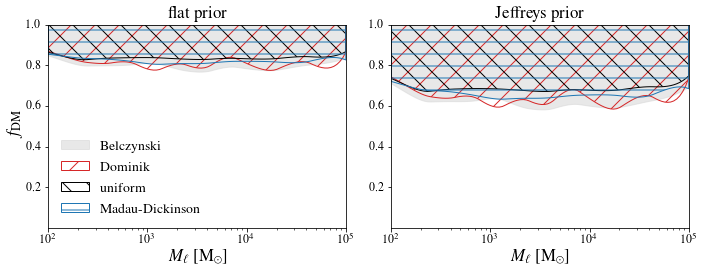

In [7]:
path_plot = '../sim_data/soummyadip_o3b/plots/final/'

# fdm_vec = np.linspace(1e-9,1.,int(1e3))
fdm_vec = np.logspace(-6,0,int(1e4))

# m_lens_vec = np.logspace(1, 6, 21)
m_lens_vec = np.logspace(2, 5, 13)

m_lens_vec = np.delete(m_lens_vec, 9)

blu_thresh = round(0.8*np.log(10), 2)

N_events_O1 = 4    #LVC + IAS = 3 + 1
N_events_O2 = 14   #LVC + IAS = 7 + 7
N_events_O3a = 36
N_events_O3b = 31

# N_events = N_events_O1 + N_events_O2 + N_events_O3a + N_events_O3b

'''The change is done here'''
N_events = N_events_O3a + N_events_O3b

runtag = 'O3aO3b_bluthresh_%.2f_Ntot_%.0f_constr_min_2022-01-10' %(blu_thresh, N_events)

zs_dist_vec = ['Belczynski', 'Dominik', 'uniform', 'O3pop']

fdm_90_vec = np.zeros_like(m_lens_vec)
m_lens_vec_intp = np.logspace(2, 5, 100)

hatches= [None, '/', '\\', '-']
facecolors = ['lightgrey', 'None', 'None', 'None']
colors = ['lightgrey', 'tab:red', 'k', 'tab:Blue']
alphas = [0.5, 1, 1, 1]

plt.figure(figsize=(10,4))
for i_p, prior in enumerate(['flat', 'Jeffreys']):
    for i_z, zs_dist in enumerate(zs_dist_vec):
        for i_m, m_lens in enumerate(m_lens_vec):

            # calculate the lensing fraction  for different noise spectra
#             u_vec_o1 = np.polyval(lens_frac_pol_coeff_o1[zs_dist][m_lens], fdm_vec)
#             u_vec_o2 = np.polyval(lens_frac_pol_coeff_o2[zs_dist][m_lens], fdm_vec)
            u_vec_o3a = np.polyval(lens_frac_pol_coeff_o3a[zs_dist][m_lens], fdm_vec)
            u_vec_o3b = np.polyval(lens_frac_pol_coeff_o3b[zs_dist][m_lens], fdm_vec)
            
            # combine them according to the right proportions 
#             u_vec = (N_events_O1*u_vec_o1 + N_events_O2*u_vec_o2 + N_events_O3a*u_vec_o3a  +\
#                      N_events_O3b*u_vec_o3b)/N_events

            '''The change is done here'''
            u_vec = (N_events_O3a*u_vec_o3a  + N_events_O3b*u_vec_o3b)/N_events
            
            # calculate the Jacobian 
            du_dfm_vec = np.gradient(u_vec)/np.gradient(fdm_vec)
            
            bad_intrp_data = np.logical_or(u_vec < 0, du_dfm_vec < 0)
            u_vec[bad_intrp_data] = 1e-9
            du_dfm_vec[bad_intrp_data] = 0

            # calculate the posterior on f_DM 
            P_fdm, fdm_90 = posterior_fdm(N_events, fdm_vec, u_vec, du_dfm_vec, prior=prior)
            fdm_90_vec[i_m] = fdm_90
            
            f = interp1d(m_lens_vec, fdm_90_vec, kind='quadratic')
            fdm_90_intp =f(m_lens_vec_intp)
        
        plt.subplot(1,2,i_p+1)
        plt.title('%s prior'%(prior), fontsize=17)
        plt.fill_between(m_lens_vec_intp, fdm_90_intp, np.ones(len(fdm_90_intp)),\
                         hatch=hatches[i_z], alpha=alphas[i_z], fc=facecolors[i_z], ec=colors[i_z],\
                         label=[zs_dist if zs_dist == 'Belczynski' or zs_dist == 'Dominik' or \
                                zs_dist == 'uniform' else 'Madau-Dickinson'][0])
    plt.xscale('log')
    plt.ylim(1e-5,1)
    plt.xlim(1e2,1e5)
    plt.xlabel('$M_\ell~[\mathrm{M_\odot}]$', fontsize=17)

plt.subplot(121)
plt.legend(frameon=False, loc=3)
plt.ylabel('$f_\mathrm{DM}$', fontsize=17)
plt.tight_layout()
plt.savefig(path_plot+'fdm_constraints_%s.pdf' %(runtag))
plt.savefig(path_plot+'fdm_constraints_%s.png' %(runtag))
plt.show()

## Modified exclusion plot but using O3a and O3b events (and PSD) only, i.e.,  $N_{\rm tot}=67$, and also, rectifying Madau-Dickinson distribution 

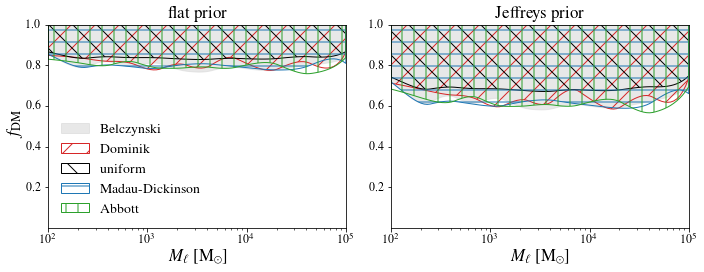

In [8]:
path_plot = '../sim_data/soummyadip_o3b/plots/final/'

# fdm_vec = np.linspace(1e-9,1.,int(1e3))
fdm_vec = np.logspace(-6,0,int(1e4))

# m_lens_vec = np.logspace(1, 6, 21)
m_lens_vec = np.logspace(2, 5, 13)

m_lens_vec = np.delete(m_lens_vec, 9)

blu_thresh = round(0.8*np.log(10), 2)

N_events_O1 = 4    #LVC + IAS = 3 + 1
N_events_O2 = 14   #LVC + IAS = 7 + 7
N_events_O3a = 36
N_events_O3b = 31

# N_events = N_events_O1 + N_events_O2 + N_events_O3a + N_events_O3b

'''The change is done here'''
N_events = N_events_O3a + N_events_O3b

runtag = 'O3aO3b_bluthresh_%.2f_Ntot_%.0f_constr_min_2022-01-10_modified' %(blu_thresh, N_events)

zs_dist_vec = ['Belczynski', 'Dominik', 'uniform', 'Madau-Dickinson', 'O3pop']

fdm_90_vec = np.zeros_like(m_lens_vec)
m_lens_vec_intp = np.logspace(2, 5, 100)

hatches= [None, '/', '\\', '-', '|']
facecolors = ['lightgrey', 'None', 'None', 'None', 'None']
colors = ['lightgrey', 'tab:red', 'k', 'tab:Blue', 'tab:green']
alphas = [0.5, 1, 1, 1, 1]

plt.figure(figsize=(10,4))
for i_p, prior in enumerate(['flat', 'Jeffreys']):
    for i_z, zs_dist in enumerate(zs_dist_vec):
        for i_m, m_lens in enumerate(m_lens_vec):

            # calculate the lensing fraction  for different noise spectra
#             u_vec_o1 = np.polyval(lens_frac_pol_coeff_o1[zs_dist][m_lens], fdm_vec)
#             u_vec_o2 = np.polyval(lens_frac_pol_coeff_o2[zs_dist][m_lens], fdm_vec)
            u_vec_o3a = np.polyval(lens_frac_pol_coeff_o3a[zs_dist][m_lens], fdm_vec)
            u_vec_o3b = np.polyval(lens_frac_pol_coeff_o3b[zs_dist][m_lens], fdm_vec)
            
            # combine them according to the right proportions 
#             u_vec = (N_events_O1*u_vec_o1 + N_events_O2*u_vec_o2 + N_events_O3a*u_vec_o3a  +\
#                      N_events_O3b*u_vec_o3b)/N_events

            '''The change is done here'''
            u_vec = (N_events_O3a*u_vec_o3a  + N_events_O3b*u_vec_o3b)/N_events
            
            # calculate the Jacobian 
            du_dfm_vec = np.gradient(u_vec)/np.gradient(fdm_vec)
            
            bad_intrp_data = np.logical_or(u_vec < 0, du_dfm_vec < 0)
            u_vec[bad_intrp_data] = 1e-9
            du_dfm_vec[bad_intrp_data] = 0

            # calculate the posterior on f_DM 
            P_fdm, fdm_90 = posterior_fdm(N_events, fdm_vec, u_vec, du_dfm_vec, prior=prior)
            fdm_90_vec[i_m] = fdm_90
            
            f = interp1d(m_lens_vec, fdm_90_vec, kind='quadratic')
            fdm_90_intp =f(m_lens_vec_intp)
        
        plt.subplot(1,2,i_p+1)
        plt.title('%s prior'%(prior), fontsize=17)
        plt.fill_between(m_lens_vec_intp, fdm_90_intp, np.ones(len(fdm_90_intp)),\
                         hatch=hatches[i_z], alpha=alphas[i_z], fc=facecolors[i_z], ec=colors[i_z],\
                         label=[zs_dist if zs_dist == 'Belczynski' or zs_dist == 'Dominik' or \
                                zs_dist == 'uniform' or zs_dist == 'Madau-Dickinson' else 'Abbott'][0])
    plt.xscale('log')
    plt.ylim(1e-5,1)
    plt.xlim(1e2,1e5)
    plt.xlabel('$M_\ell~[\mathrm{M_\odot}]$', fontsize=17)

plt.subplot(121)
plt.legend(frameon=False, loc=3)
plt.ylabel('$f_\mathrm{DM}$', fontsize=17)
plt.tight_layout()
plt.savefig(path_plot+'fdm_constraints_%s.pdf' %(runtag))
plt.savefig(path_plot+'fdm_constraints_%s.png' %(runtag))
plt.show()

## $f_\mathrm{DM}$ min-max exclusion plot [ln$B^L_U = 1.84$ (log$_{10}B^L_U = 0.8$), $N_\mathrm{tot} = 85$ (Including O3b PSD)] for power-law+peak source mass and Madau-Dickinson redshift distributions

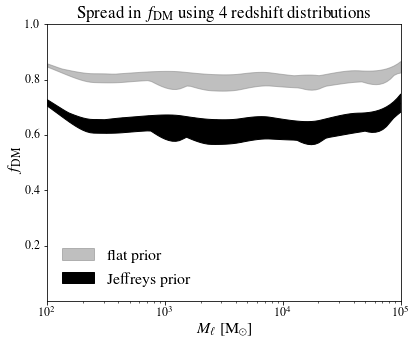

In [31]:
path_plot = '../sim_data/soummyadip_o3b/plots/final/'

# fdm_vec = np.linspace(1e-9,1.,int(1e3))
fdm_vec = np.logspace(-6,0,int(1e4))

# m_lens_vec = np.logspace(1, 6, 21)
m_lens_vec = np.logspace(2, 5, 13)

m_lens_vec = np.delete(m_lens_vec, 9)

blu_thresh = round(0.8*np.log(10), 2)

N_events_O1 = 4    #LVC + IAS = 3 + 1
N_events_O2 = 14   #LVC + IAS = 7 + 7
N_events_O3a = 36
N_events_O3b = 31
N_events = N_events_O1 + N_events_O2 + N_events_O3a + N_events_O3b

runtag = 'O1O2O3aO3b_bluthresh_%.2f_Ntot_%.0f_constr_min_2022-01-10' %(blu_thresh, N_events)

zs_dist_vec = ['Belczynski', 'Dominik', 'uniform', 'O3pop']

fdm_90_vec = np.zeros_like(m_lens_vec)
m_lens_vec_intp = np.logspace(2, 5, 100)

hatches= [None, '/']
facecolors = ['grey', 'k']
colors = ['grey', 'k']
alphas = [0.5, 1]

plt.figure(figsize=(6,5))
for i_p, prior in enumerate(['flat', 'Jeffreys']):
    
    fdm_90_intep_zmodel = []
    for i_z, zs_dist in enumerate(zs_dist_vec):

        for i_m, m_lens in enumerate(m_lens_vec):

            # calculate the lensing fraction  for different noise spectra
            u_vec_o1 = np.polyval(lens_frac_pol_coeff_o1[zs_dist][m_lens], fdm_vec)
            u_vec_o2 = np.polyval(lens_frac_pol_coeff_o2[zs_dist][m_lens], fdm_vec)
            u_vec_o3a = np.polyval(lens_frac_pol_coeff_o3a[zs_dist][m_lens], fdm_vec)
            u_vec_o3b = np.polyval(lens_frac_pol_coeff_o3b[zs_dist][m_lens], fdm_vec)
            
            # combine them according to the right proportions 
            u_vec = (N_events_O1*u_vec_o1 + N_events_O2*u_vec_o2 + N_events_O3a*u_vec_o3a  +\
                     N_events_O3b*u_vec_o3b)/N_events
            
            # calculate the Jacobian 
            du_dfm_vec = np.gradient(u_vec)/np.gradient(fdm_vec)
            
            bad_intrp_data = np.logical_or(u_vec < 0, du_dfm_vec < 0)
            u_vec[bad_intrp_data] = 1e-9
            du_dfm_vec[bad_intrp_data] = 0

            # calculate the posterior on f_DM 
            P_fdm, fdm_90 = posterior_fdm(N_events, fdm_vec, u_vec, du_dfm_vec, prior=prior)
            fdm_90_vec[i_m] = fdm_90
            
            f = interp1d(m_lens_vec, fdm_90_vec, kind='quadratic')
            fdm_90_intp = f(m_lens_vec_intp)
        fdm_90_intep_zmodel.append(fdm_90_intp)
   
    fdm_min = []
    fdm_max = []
    for j in range(len(m_lens_vec_intp)):
        arr = []
        for i in fdm_90_intep_zmodel:
            arr.append(i[j])
        fdm_min.append(min(arr))
        fdm_max.append(max(arr))
        
#     plt.subplot(1,2,i_p+1)
    plt.fill_between(m_lens_vec_intp, fdm_min, fdm_max, hatch=hatches[i_p], alpha=alphas[i_p],\
                     fc=facecolors[i_p], ec=colors[i_p], label='%s prior'%(prior))
    plt.xscale('log')
    plt.ylim(1e-5,1)
    plt.xlim(1e2,1e5)
    plt.xlabel('$M_\ell~[\mathrm{M_\odot}]$', fontsize=16)
    plt.legend(frameon=False, fontsize=16, loc='lower left')
# plt.subplot(111)
plt.title('Spread in $f_\mathrm{DM}$ using 4 redshift distributions', fontsize=17)
plt.ylabel('$f_\mathrm{DM}$', fontsize=16)
plt.tight_layout()
plt.savefig(path_plot+'fdm_constraints_fdm_min_max_%s.pdf' %(runtag))
plt.savefig(path_plot+'fdm_constraints_fdm_min_max_%s.png' %(runtag))
plt.show()

## Modified $f_\mathrm{DM}$ min-max exclusion plot but using O3a and O3b events (and PSD) only, i.e., $N_{\rm{tot}} = 67$

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


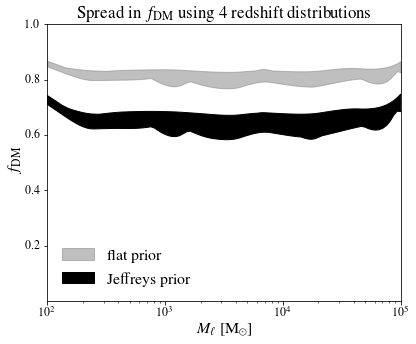

In [8]:
path_plot = '../sim_data/soummyadip_o3b/plots/final/'

# fdm_vec = np.linspace(1e-9,1.,int(1e3))
fdm_vec = np.logspace(-6,0,int(1e4))

# m_lens_vec = np.logspace(1, 6, 21)
m_lens_vec = np.logspace(2, 5, 13)

m_lens_vec = np.delete(m_lens_vec, 9)

blu_thresh = round(0.8*np.log(10), 2)

N_events_O1 = 4    #LVC + IAS = 3 + 1
N_events_O2 = 14   #LVC + IAS = 7 + 7
N_events_O3a = 36
N_events_O3b = 31

# N_events = N_events_O1 + N_events_O2 + N_events_O3a + N_events_O3b

'''The change is done here'''
N_events = N_events_O3a + N_events_O3b

runtag = 'O3aO3b_bluthresh_%.2f_Ntot_%.0f_constr_min_2022-01-10' %(blu_thresh, N_events)

zs_dist_vec = ['Belczynski', 'Dominik', 'uniform', 'O3pop']

fdm_90_vec = np.zeros_like(m_lens_vec)
m_lens_vec_intp = np.logspace(2, 5, 100)

hatches= [None, '/']
facecolors = ['grey', 'k']
colors = ['grey', 'k']
alphas = [0.5, 1]

plt.figure(figsize=(6,5))
for i_p, prior in enumerate(['flat', 'Jeffreys']):
    
    fdm_90_intep_zmodel = []
    for i_z, zs_dist in enumerate(zs_dist_vec):

        for i_m, m_lens in enumerate(m_lens_vec):

            # calculate the lensing fraction  for different noise spectra
#             u_vec_o1 = np.polyval(lens_frac_pol_coeff_o1[zs_dist][m_lens], fdm_vec)
#             u_vec_o2 = np.polyval(lens_frac_pol_coeff_o2[zs_dist][m_lens], fdm_vec)
            u_vec_o3a = np.polyval(lens_frac_pol_coeff_o3a[zs_dist][m_lens], fdm_vec)
            u_vec_o3b = np.polyval(lens_frac_pol_coeff_o3b[zs_dist][m_lens], fdm_vec)
            
            # combine them according to the right proportions 
#             u_vec = (N_events_O1*u_vec_o1 + N_events_O2*u_vec_o2 + N_events_O3a*u_vec_o3a  +\
#                      N_events_O3b*u_vec_o3b)/N_events

            '''The change is done here'''
            u_vec = (N_events_O3a*u_vec_o3a  + N_events_O3b*u_vec_o3b)/N_events
            
            # calculate the Jacobian 
            du_dfm_vec = np.gradient(u_vec)/np.gradient(fdm_vec)
            
            bad_intrp_data = np.logical_or(u_vec < 0, du_dfm_vec < 0)
            u_vec[bad_intrp_data] = 1e-9
            du_dfm_vec[bad_intrp_data] = 0

            # calculate the posterior on f_DM 
            P_fdm, fdm_90 = posterior_fdm(N_events, fdm_vec, u_vec, du_dfm_vec, prior=prior)
            fdm_90_vec[i_m] = fdm_90
            
            f = interp1d(m_lens_vec, fdm_90_vec, kind='quadratic')
            fdm_90_intp = f(m_lens_vec_intp)
        fdm_90_intep_zmodel.append(fdm_90_intp)
   
    fdm_min = []
    fdm_max = []
    for j in range(len(m_lens_vec_intp)):
        arr = []
        for i in fdm_90_intep_zmodel:
            arr.append(i[j])
        fdm_min.append(min(arr))
        fdm_max.append(max(arr))
        
#     plt.subplot(1,2,i_p+1)
    plt.fill_between(m_lens_vec_intp, fdm_min, fdm_max, hatch=hatches[i_p], alpha=alphas[i_p],\
                     fc=facecolors[i_p], ec=colors[i_p], label='%s prior'%(prior))
    plt.xscale('log')
    plt.ylim(1e-5,1)
    plt.xlim(1e2,1e5)
    plt.xlabel('$M_\ell~[\mathrm{M_\odot}]$', fontsize=16)
    plt.legend(frameon=False, fontsize=16, loc='lower left')
# plt.subplot(111)
plt.title('Spread in $f_\mathrm{DM}$ using 4 redshift distributions', fontsize=17)
plt.ylabel('$f_\mathrm{DM}$', fontsize=16)
plt.tight_layout()
plt.savefig(path_plot+'fdm_constraints_fdm_min_max_%s.pdf' %(runtag))
plt.savefig(path_plot+'fdm_constraints_fdm_min_max_%s.png' %(runtag))
plt.show()

## Modified $f_{\rm DM}$ min-max exclusion plot but using O3a and O3b events (and PSD) only, i.e.,  $N_{\rm tot}=67$, and also, rectifying Madau-Dickinson distribution

### Using 4 redshift distributions

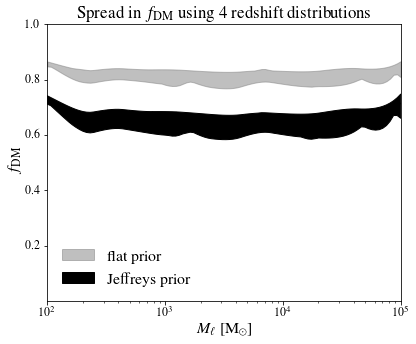

In [9]:
path_plot = '../sim_data/soummyadip_o3b/plots/final/'

# fdm_vec = np.linspace(1e-9,1.,int(1e3))
fdm_vec = np.logspace(-6,0,int(1e4))

# m_lens_vec = np.logspace(1, 6, 21)
m_lens_vec = np.logspace(2, 5, 13)

m_lens_vec = np.delete(m_lens_vec, 9)

blu_thresh = round(0.8*np.log(10), 2)

N_events_O1 = 4    #LVC + IAS = 3 + 1
N_events_O2 = 14   #LVC + IAS = 7 + 7
N_events_O3a = 36
N_events_O3b = 31

# N_events = N_events_O1 + N_events_O2 + N_events_O3a + N_events_O3b

'''The change is done here'''
N_events = N_events_O3a + N_events_O3b

runtag = 'O3aO3b_bluthresh_%.2f_Ntot_%.0f_constr_min_2022-01-10_modified' %(blu_thresh, N_events)

zs_dist_vec = ['Belczynski', 'Dominik', 'uniform', 'Madau-Dickinson']

fdm_90_vec = np.zeros_like(m_lens_vec)
m_lens_vec_intp = np.logspace(2, 5, 100)

hatches= [None, '/']
facecolors = ['grey', 'k']
colors = ['grey', 'k']
alphas = [0.5, 1]

plt.figure(figsize=(6,5))
for i_p, prior in enumerate(['flat', 'Jeffreys']):
    
    fdm_90_intep_zmodel = []
    for i_z, zs_dist in enumerate(zs_dist_vec):

        for i_m, m_lens in enumerate(m_lens_vec):

            # calculate the lensing fraction  for different noise spectra
#             u_vec_o1 = np.polyval(lens_frac_pol_coeff_o1[zs_dist][m_lens], fdm_vec)
#             u_vec_o2 = np.polyval(lens_frac_pol_coeff_o2[zs_dist][m_lens], fdm_vec)
            u_vec_o3a = np.polyval(lens_frac_pol_coeff_o3a[zs_dist][m_lens], fdm_vec)
            u_vec_o3b = np.polyval(lens_frac_pol_coeff_o3b[zs_dist][m_lens], fdm_vec)
            
            # combine them according to the right proportions 
#             u_vec = (N_events_O1*u_vec_o1 + N_events_O2*u_vec_o2 + N_events_O3a*u_vec_o3a  +\
#                      N_events_O3b*u_vec_o3b)/N_events

            '''The change is done here'''
            u_vec = (N_events_O3a*u_vec_o3a  + N_events_O3b*u_vec_o3b)/N_events
            
            # calculate the Jacobian 
            du_dfm_vec = np.gradient(u_vec)/np.gradient(fdm_vec)
            
            bad_intrp_data = np.logical_or(u_vec < 0, du_dfm_vec < 0)
            u_vec[bad_intrp_data] = 1e-9
            du_dfm_vec[bad_intrp_data] = 0

            # calculate the posterior on f_DM 
            P_fdm, fdm_90 = posterior_fdm(N_events, fdm_vec, u_vec, du_dfm_vec, prior=prior)
            fdm_90_vec[i_m] = fdm_90
            
            f = interp1d(m_lens_vec, fdm_90_vec, kind='quadratic')
            fdm_90_intp = f(m_lens_vec_intp)
        fdm_90_intep_zmodel.append(fdm_90_intp)
   
    fdm_min = []
    fdm_max = []
    for j in range(len(m_lens_vec_intp)):
        arr = []
        for i in fdm_90_intep_zmodel:
            arr.append(i[j])
        fdm_min.append(min(arr))
        fdm_max.append(max(arr))
        
#     plt.subplot(1,2,i_p+1)
    plt.fill_between(m_lens_vec_intp, fdm_min, fdm_max, hatch=hatches[i_p], alpha=alphas[i_p],\
                     fc=facecolors[i_p], ec=colors[i_p], label='%s prior'%(prior))
    plt.xscale('log')
    plt.ylim(1e-5,1)
    plt.xlim(1e2,1e5)
    plt.xlabel('$M_\ell~[\mathrm{M_\odot}]$', fontsize=16)
    plt.legend(frameon=False, fontsize=16, loc='lower left')
# plt.subplot(111)
plt.title('Spread in $f_\mathrm{DM}$ using 4 redshift distributions', fontsize=17)
plt.ylabel('$f_\mathrm{DM}$', fontsize=16)
plt.tight_layout()
plt.savefig(path_plot+'fdm_constraints_fdm_min_max_4_distr_%s.pdf' %(runtag))
plt.savefig(path_plot+'fdm_constraints_fdm_min_max_4_distr_%s.png' %(runtag))
plt.show()

### Using 5 redshift distributions

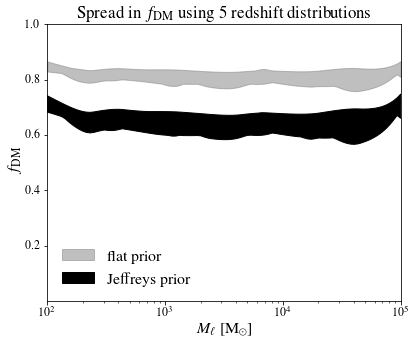

In [10]:
path_plot = '../sim_data/soummyadip_o3b/plots/final/'

# fdm_vec = np.linspace(1e-9,1.,int(1e3))
fdm_vec = np.logspace(-6,0,int(1e4))

# m_lens_vec = np.logspace(1, 6, 21)
m_lens_vec = np.logspace(2, 5, 13)

m_lens_vec = np.delete(m_lens_vec, 9)

blu_thresh = round(0.8*np.log(10), 2)

N_events_O1 = 4    #LVC + IAS = 3 + 1
N_events_O2 = 14   #LVC + IAS = 7 + 7
N_events_O3a = 36
N_events_O3b = 31

# N_events = N_events_O1 + N_events_O2 + N_events_O3a + N_events_O3b

'''The change is done here'''
N_events = N_events_O3a + N_events_O3b

runtag = 'O3aO3b_bluthresh_%.2f_Ntot_%.0f_constr_min_2022-01-10_modified' %(blu_thresh, N_events)

zs_dist_vec = ['Belczynski', 'Dominik', 'uniform', 'Madau-Dickinson', 'O3pop']

fdm_90_vec = np.zeros_like(m_lens_vec)
m_lens_vec_intp = np.logspace(2, 5, 100)

hatches= [None, '/']
facecolors = ['grey', 'k']
colors = ['grey', 'k']
alphas = [0.5, 1]

plt.figure(figsize=(6,5))
for i_p, prior in enumerate(['flat', 'Jeffreys']):
    
    fdm_90_intep_zmodel = []
    for i_z, zs_dist in enumerate(zs_dist_vec):

        for i_m, m_lens in enumerate(m_lens_vec):

            # calculate the lensing fraction  for different noise spectra
#             u_vec_o1 = np.polyval(lens_frac_pol_coeff_o1[zs_dist][m_lens], fdm_vec)
#             u_vec_o2 = np.polyval(lens_frac_pol_coeff_o2[zs_dist][m_lens], fdm_vec)
            u_vec_o3a = np.polyval(lens_frac_pol_coeff_o3a[zs_dist][m_lens], fdm_vec)
            u_vec_o3b = np.polyval(lens_frac_pol_coeff_o3b[zs_dist][m_lens], fdm_vec)
            
            # combine them according to the right proportions 
#             u_vec = (N_events_O1*u_vec_o1 + N_events_O2*u_vec_o2 + N_events_O3a*u_vec_o3a  +\
#                      N_events_O3b*u_vec_o3b)/N_events

            '''The change is done here'''
            u_vec = (N_events_O3a*u_vec_o3a  + N_events_O3b*u_vec_o3b)/N_events
            
            # calculate the Jacobian 
            du_dfm_vec = np.gradient(u_vec)/np.gradient(fdm_vec)
            
            bad_intrp_data = np.logical_or(u_vec < 0, du_dfm_vec < 0)
            u_vec[bad_intrp_data] = 1e-9
            du_dfm_vec[bad_intrp_data] = 0

            # calculate the posterior on f_DM 
            P_fdm, fdm_90 = posterior_fdm(N_events, fdm_vec, u_vec, du_dfm_vec, prior=prior)
            fdm_90_vec[i_m] = fdm_90
            
            f = interp1d(m_lens_vec, fdm_90_vec, kind='quadratic')
            fdm_90_intp = f(m_lens_vec_intp)
        fdm_90_intep_zmodel.append(fdm_90_intp)
   
    fdm_min = []
    fdm_max = []
    for j in range(len(m_lens_vec_intp)):
        arr = []
        for i in fdm_90_intep_zmodel:
            arr.append(i[j])
        fdm_min.append(min(arr))
        fdm_max.append(max(arr))
        
#     plt.subplot(1,2,i_p+1)
    plt.fill_between(m_lens_vec_intp, fdm_min, fdm_max, hatch=hatches[i_p], alpha=alphas[i_p],\
                     fc=facecolors[i_p], ec=colors[i_p], label='%s prior'%(prior))
    plt.xscale('log')
    plt.ylim(1e-5,1)
    plt.xlim(1e2,1e5)
    plt.xlabel('$M_\ell~[\mathrm{M_\odot}]$', fontsize=16)
    plt.legend(frameon=False, fontsize=16, loc='lower left')
# plt.subplot(111)
plt.title('Spread in $f_\mathrm{DM}$ using 5 redshift distributions', fontsize=17)
plt.ylabel('$f_\mathrm{DM}$', fontsize=16)
plt.tight_layout()
plt.savefig(path_plot+'fdm_constraints_fdm_min_max_5_distr_%s.pdf' %(runtag))
plt.savefig(path_plot+'fdm_constraints_fdm_min_max_5_distr_%s.png' %(runtag))
plt.show()